# Livrable 1 - Classification binaire

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import ResNet50
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import numpy as np
import os
import random
from tensorflow.keras.preprocessing.image import load_img
import pandas as pd
from tqdm.notebook import tqdm

# analyses de données exploratoires et Pré traitement des données

In [10]:
# Base path setup for data sets download v1
base_dir = os.getcwd()
relative_path = r"..\..\..\DataSets\data_set_livrable_1"
dataset_dir = os.path.normpath(os.path.join(base_dir, relative_path))

In [3]:
from PIL import Image
import os
import pandas as pd

# Fonction pour vérifier les images corrompues et calculer la variance des pixels
def check_all_images_for_corruption_and_variance(directory):
    results = []
    categories = ['Image', 'Photo']
    
    for category in categories:
        if category == 'Image':
            subcategories = ['Painting', 'Schematics', 'Sketch', 'Text']
            for subcategory in subcategories:
                subcategory_path = os.path.join(directory, 'Image', subcategory)
                if os.path.exists(subcategory_path):
                    total_images = 0
                    corrupted_images = 0
                    low_variance_images = 0
                    for file in os.listdir(subcategory_path):
                        img_path = os.path.join(subcategory_path, file)
                        if os.path.isfile(img_path):
                            total_images += 1
                            try:
                                img = Image.open(img_path)
                                img.verify()  # Vérifie si l'image est corrompue
                                # Réouvrir pour calculer la variance des pixels
                                img = Image.open(img_path).convert('RGB')
                                img_array = np.array(img)
                                variance = np.var(img_array)
                                if variance < 50:  # Détecte les images à faible variance
                                    low_variance_images += 1
                            except (IOError, SyntaxError) as e:
                                corrupted_images += 1
                    results.append([subcategory, total_images, corrupted_images, low_variance_images])
        
        elif category == 'Photo':
            photo_path = os.path.join(directory, 'Photo')
            if os.path.exists(photo_path):
                total_images = 0
                corrupted_images = 0
                low_variance_images = 0
                for file in os.listdir(photo_path):
                    img_path = os.path.join(photo_path, file)
                    if os.path.isfile(img_path):
                        total_images += 1
                        try:
                            img = Image.open(img_path)
                            img.verify()  # Vérifie si l'image est corrompue
                            # Réouvrir pour calculer la variance des pixels
                            img = Image.open(img_path).convert('RGB')
                            img_array = np.array(img)
                            variance = np.var(img_array)
                            if variance < 50:  # Détecte les images à faible variance
                                low_variance_images += 1
                        except (IOError, SyntaxError) as e:
                            corrupted_images += 1
                results.append(['Photo', total_images, corrupted_images, low_variance_images])

    return results

def display_corruption_and_variance_stats(results):
    df = pd.DataFrame(results, columns=['Category', 'Total Images', 'Corrupted Images', 'Low Variance Images'])
    df['Proportion Corrupted (%)'] = (df['Corrupted Images'] / df['Total Images']) * 100
    df['Proportion Low Variance (%)'] = (df['Low Variance Images'] / df['Total Images']) * 100

    print(df)



In [4]:
results = check_all_images_for_corruption_and_variance(dataset_dir)
display_corruption_and_variance_stats(results)


     Category  Total Images  Corrupted Images  Low Variance Images  \
0    Painting          1920                 0                    0   
1  Schematics         10001                 1                  163   
2      Sketch          1406                 0                    0   
3        Text         10000                 0                   19   
4       Photo          9997                 0                    0   

   Proportion Corrupted (%)  Proportion Low Variance (%)  
0                  0.000000                     0.000000  
1                  0.009999                     1.629837  
2                  0.000000                     0.000000  
3                  0.000000                     0.190000  
4                  0.000000                     0.000000  


## création du data set clean

In [5]:
import os
import shutil
import pandas as pd
from PIL import Image
import numpy as np
from tqdm.notebook import tqdm  

# Fonction pour vérifier si une image est corrompue ou à faible variance
def check_image_quality(img_path):
    try:
        # Vérifier si l'image est corrompue
        img = Image.open(img_path)
        img.verify()  # Vérifie si l'image est corrompue
        
        # Réouvrir pour vérifier la variance des pixels
        img = Image.open(img_path).convert('RGB')
        img_array = np.array(img)
        variance = np.var(img_array)
        
        # Considérer l'image comme "de faible qualité" si la variance est inférieure à un seuil
        if variance < 50:  # Ajuster ce seuil si nécessaire
            return "Low Variance"
        return "Valid"
    
    except (IOError, SyntaxError):
        return "Corrupted"

# Fonction pour vérifier si le dossier est déjà rempli
def is_folder_filled(folder_path):
    total_files = sum([len(files) for r, d, files in os.walk(folder_path)])
    return total_files > 0

# Fonction pour analyser tout le dataset et générer un DataFrame des images corrompues et de faible qualité
def analyze_dataset_for_issues(dataset_dir):
    categories = ['Image', 'Photo']
    invalid_images_list = []
    
    for category in categories:
        if category == 'Image':
            subcategories = ['Painting', 'Schematics', 'Sketch', 'Text']
            for subcategory in subcategories:
                subcategory_path = os.path.join(dataset_dir, 'Image', subcategory)
                if os.path.exists(subcategory_path):
                    img_files = [f for f in os.listdir(subcategory_path) if os.path.isfile(os.path.join(subcategory_path, f))]
                    
                    # Ajout de la barre de progression ici pour chaque sous-catégorie
                    for img_file in tqdm(img_files, desc=f"Processing {subcategory}", leave=False):
                        img_path = os.path.join(subcategory_path, img_file)
                        quality_status = check_image_quality(img_path)
                        if quality_status != "Valid":
                            invalid_images_list.append({'Filename': img_file, 'Category': subcategory, 'Issue': quality_status})
        
        elif category == 'Photo':
            photo_path = os.path.join(dataset_dir, 'Photo')
            if os.path.exists(photo_path):
                img_files = [f for f in os.listdir(photo_path) if os.path.isfile(os.path.join(photo_path, f))]
                
                # Ajout de la barre de progression pour la catégorie "Photo"
                for img_file in tqdm(img_files, desc="Processing Photo", leave=False):
                    img_path = os.path.join(photo_path, img_file)
                    quality_status = check_image_quality(img_path)
                    if quality_status != "Valid":
                        invalid_images_list.append({'Filename': img_file, 'Category': 'Photo', 'Issue': quality_status})
    
    # Convertir la liste en DataFrame
    df_invalid_images = pd.DataFrame(invalid_images_list)
    return df_invalid_images

# Fonction pour créer un dataset clean en excluant les images corrompues ou à faible variance
def create_clean_dataset(df_invalid_images, dataset_dir, new_clean_dir):
    categories = ['Image', 'Photo']
    
    # Créer le dossier du nouveau dataset clean
    os.makedirs(new_clean_dir, exist_ok=True)

    if is_folder_filled(new_clean_dir):
        print(f"Le dossier {new_clean_dir} est déjà rempli. Skipping process.")
        return  # Si le dossier est déjà rempli, on arrête ici pour éviter de refaire la copie.
    
    for category in categories:
        if category == 'Image':
            subcategories = ['Painting', 'Schematics', 'Sketch', 'Text']
            for subcategory in subcategories:
                subcategory_path = os.path.join(dataset_dir, 'Image', subcategory)
                if os.path.exists(subcategory_path):
                    new_subcategory_path = os.path.join(new_clean_dir, 'Image', subcategory)
                    os.makedirs(new_subcategory_path, exist_ok=True)
                    
                    img_files = [f for f in os.listdir(subcategory_path) if os.path.isfile(os.path.join(subcategory_path, f))]
                    
                    # Ajout de la barre de progression ici pour la copie des fichiers valides
                    for img_file in tqdm(img_files, desc=f"Copying {subcategory}", leave=False):
                        img_path = os.path.join(subcategory_path, img_file)
                        new_img_path = os.path.join(new_subcategory_path, img_file)

                        # Vérifier si l'image est corrompue ou à faible variance
                        if not ((df_invalid_images['Filename'] == img_file) & (df_invalid_images['Category'] == subcategory)).any():
                            shutil.copy(img_path, new_img_path)
        
        elif category == 'Photo':
            photo_path = os.path.join(dataset_dir, 'Photo')
            new_photo_path = os.path.join(new_clean_dir, 'Photo')
            os.makedirs(new_photo_path, exist_ok=True)
            
            img_files = [f for f in os.listdir(photo_path) if os.path.isfile(os.path.join(photo_path, f))]
            
            # Ajout de la barre de progression pour la copie des photos
            for img_file in tqdm(img_files, desc="Copying Photo", leave=False):
                img_path = os.path.join(photo_path, img_file)
                new_img_path = os.path.join(new_photo_path, img_file)

                # Vérifier si l'image est corrompue ou à faible variance
                if not ((df_invalid_images['Filename'] == img_file) & (df_invalid_images['Category'] == 'Photo')).any():
                    shutil.copy(img_path, new_img_path)


# Chemin vers le nouveau dataset clean
new_clean_dir = os.path.normpath(os.path.join(dataset_dir, r"..\clean_dataset"))

# Vérifier si le dataset clean est déjà rempli
if not is_folder_filled(new_clean_dir):
    # Analyser tout le dataset pour identifier les images corrompues et à faible variance
    df_invalid_images = analyze_dataset_for_issues(dataset_dir)

    # Créer le dataset clean en excluant les images problématiques
    create_clean_dataset(df_invalid_images, dataset_dir, new_clean_dir)
else:
    print(f"Le dataset clean est déjà rempli dans {new_clean_dir}.")


Processing Painting:   0%|          | 0/1920 [00:00<?, ?it/s]

Processing Schematics:   0%|          | 0/10001 [00:00<?, ?it/s]

Processing Sketch:   0%|          | 0/1406 [00:00<?, ?it/s]

Processing Text:   0%|          | 0/10000 [00:00<?, ?it/s]

Processing Photo:   0%|          | 0/9997 [00:00<?, ?it/s]

Copying Painting:   0%|          | 0/1920 [00:00<?, ?it/s]

Copying Schematics:   0%|          | 0/10001 [00:00<?, ?it/s]

Copying Sketch:   0%|          | 0/1406 [00:00<?, ?it/s]

Copying Text:   0%|          | 0/10000 [00:00<?, ?it/s]

Copying Photo:   0%|          | 0/9997 [00:00<?, ?it/s]

In [6]:
def analyze_dataset_with_nested_categories(dataset_dir):
    categories = ['Image', 'Photo']  
    image_data = []
    
    for category in categories:
        category_path = os.path.join(dataset_dir, category)
        
        if category == 'Image':
            subcategories = ['Painting', 'Schematics', 'Sketch', 'Text']
            for subcategory in subcategories:
                subcategory_path = os.path.join(category_path, subcategory)
                if os.path.exists(subcategory_path):
                    img_files = [f for f in os.listdir(subcategory_path) if os.path.isfile(os.path.join(subcategory_path, f))]
                    

                    print(f"Processing {subcategory}, found {len(img_files)} files.")
                    
                    for img_file in img_files:
                        img_path = os.path.join(subcategory_path, img_file)
                        try:
                            img = load_img(img_path)
                            width, height = img.size
                            image_data.append([img_file, width, height, subcategory]) 
                        except Exception as e:
                            print(f"Could not process image: {img_file} in {subcategory}, Error: {e}")
        
        elif category == 'Photo':
            if os.path.exists(category_path):
                img_files = [f for f in os.listdir(category_path) if os.path.isfile(os.path.join(category_path, f))]

                print(f"Processing Photo, found {len(img_files)} files.")
                
                for img_file in img_files:
                    img_path = os.path.join(category_path, img_file)
                    try:
                        img = load_img(img_path)
                        width, height = img.size
                        image_data.append([img_file, width, height, 'Photo'])  # Add 'Photo' as label
                    except Exception as e:
                        print(f"Could not process image: {img_file} in Photo, Error: {e}")
    

    df = pd.DataFrame(image_data, columns=["Filename", "Width", "Height", "Category"])
    
    
    return df

In [8]:
# Analyze the dataset
df = analyze_dataset_with_nested_categories(new_clean_dir)

Processing Painting, found 1920 files.
Processing Schematics, found 9837 files.
Processing Sketch, found 1406 files.
Processing Text, found 9981 files.
Processing Photo, found 9997 files.


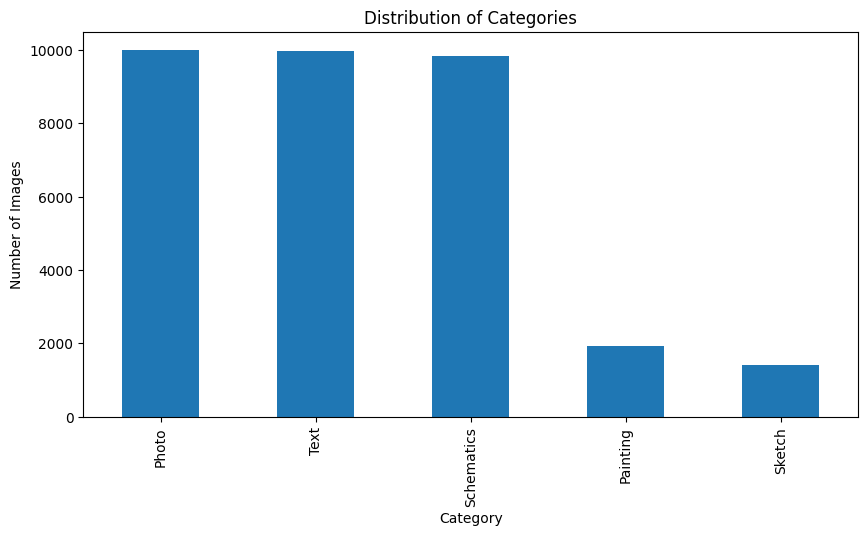

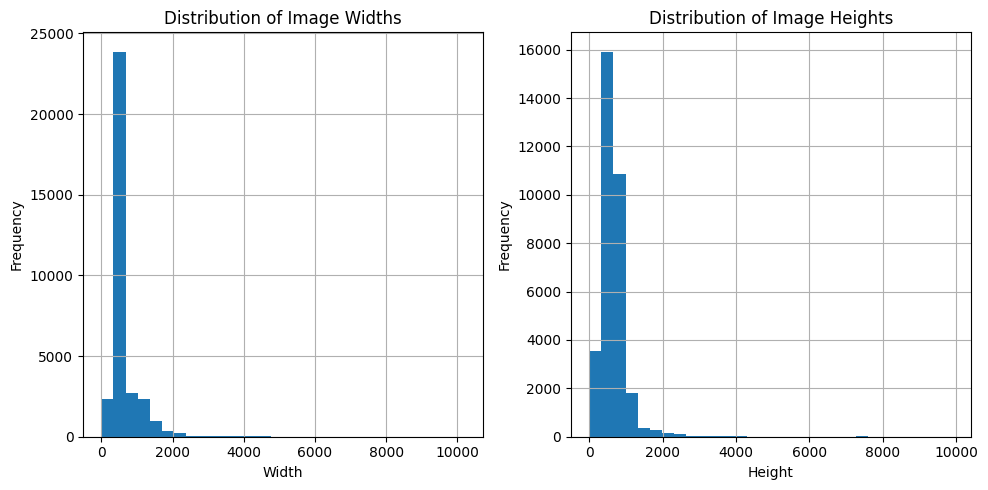

In [9]:

# Visualize the distribution of categories (including subcategories)
plt.figure(figsize=(10, 5))
df['Category'].value_counts().plot(kind='bar')
plt.title('Distribution of Categories')
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.show()

# Visualize the distribution of image dimensions across all categories
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
df['Width'].hist(bins=30)
plt.title('Distribution of Image Widths')
plt.xlabel('Width')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
df['Height'].hist(bins=30)
plt.title('Distribution of Image Heights')
plt.xlabel
plt.xlabel('Height')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()




In [13]:
new_aug_dir = os.path.normpath(os.path.join(dataset_dir, r"..\Rebanced_DataSets\augmentation"))
dataset_dir = new_aug_dir

def count_images_in_folder(folder_path):
    return len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])

painting_path = os.path.join(dataset_dir, 'Image', 'Painting')
schematics_path = os.path.join(dataset_dir, 'Image', 'Schematics')
sketch_path = os.path.join(dataset_dir, 'Image', 'Sketch')
text_path = os.path.join(dataset_dir, 'Image', 'text')
num_photos = os.path.join(dataset_dir, 'photo')


num_paintings = count_images_in_folder(painting_path)
num_schematics = count_images_in_folder(schematics_path)
num_sketches = count_images_in_folder(sketch_path)
num_path = count_images_in_folder(text_path)
num_photos = count_images_in_folder(num_photos)
image = num_paintings+num_schematics+num_sketches+num_path



print(f"Paintings: {num_paintings}, Schematics: {num_schematics}, Sketches: {num_sketches},text:{num_path}, photo:{num_photos}, images:{image}")

Paintings: 1920, Schematics: 9837, Sketches: 1406,text:9981, photo:23327, images:23144


In [14]:
# Fonction pour compter les images dans un dossier
def count_images_in_folder(folder_path):
    return len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])

## Rescale (normalisation)

Le paramètre rescale=1./255 normalise les valeurs des pixels de l'image en les divisant par 255. Cela signifie que les valeurs des pixels, qui sont normalement dans la plage de 0 à 255 (puisque les images sont généralement encodées en 8 bits), sont mises à l'échelle pour être comprises entre 0 et 1.

et aussi un réechantillonage en focntion des poids des classe

In [15]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)  

## Split des données


In [16]:
batch_size = 32

train_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)


validation_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

Found 37178 images belonging to 2 classes.
Found 9293 images belonging to 2 classes.


Dans notre cas, le déséquilibre entre "Image" et "Photo" est modéré (ce que semble indiquer nos poids de classe), nous allons commencer avec l'utilisation des poids de classe. C'est une solution simple et efficace dans la plupart des cas, surtout si l'écart entre les classes n'est pas trop important.

Sinon après analyse des performances, si nous constatons que la classe minoritaire n'est toujours pas bien apprise, nous pouvez alors envisager d'ajouter un rééchantillonnage pour cette classe en appliquant des techniques de data augmentation sur les images de la classe "Image".
redimensionnement et orientation différente de s image (ex 18 degres, ect.. workshop 2)



### Création du modèle CNN 

In [17]:
model = Sequential()

In [18]:

model.add(layers.Rescaling(1./255, input_shape=(128, 128, 3)))


c:\Users\steve\Documents\GitHub\DataSciencePictureDesc\data-science-env\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [19]:
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


In [20]:
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


In [21]:
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


In [22]:
model.add(Flatten())

In [23]:
model.add(Dense(128, activation='relu'))

In [24]:
model.add(Dropout(0.5))  

In [25]:
model.add(Dense(64, activation='relu'))

In [26]:
model.add(Dense(1, activation='sigmoid'))

In [27]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,312,961 (12.64 MB)

 Trainable params: 3,312,961 (12.64 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

## Entrainement du modèle

In [29]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
)

Epoch 1/10


c:\Users\steve\Documents\GitHub\DataSciencePictureDesc\data-science-env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1162/1162 ━━━━━━━━━━━━━━━━━━━━ 623s 532ms/step - accuracy: 0.8756 - loss: 0.3150 - val_accuracy: 0.6978 - val_loss: 0.6602
Epoch 2/10
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 388s 333ms/step - accuracy: 0.9181 - loss: 0.2387 - val_accuracy: 0.7062 - val_loss: 0.6823
Epoch 3/10
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 372s 320ms/step - accuracy: 0.9261 - loss: 0.2045 - val_accuracy: 0.7503 - val_loss: 0.5505
Epoch 4/10
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 319s 274ms/step - accuracy: 0.9376 - loss: 0.1666 - val_accuracy: 0.7250 - val_loss: 0.6386
Epoch 5/10
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 313s 268ms/step - accuracy: 0.9426 - loss: 0.1533 - val_accuracy: 0.7841 - val_loss: 0.4773
Epoch 6/10
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 307s 263ms/step - accuracy: 0.9513 - loss: 0.1352 - val_accuracy: 0.7670 - val_loss: 0.7046
Epoch 7/10
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 329s 283ms/step - accuracy: 0.9576 - loss: 0.1160 - val_accuracy: 0.7762 - val_loss: 0.5591
Epoch 8/10
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 330s 283ms/step - accuracy: 0.9

## Sauvegarde des poids

In [30]:
model.save_weights('model_aumentation.weights.h5')

# Performance du modèle 

In [31]:
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

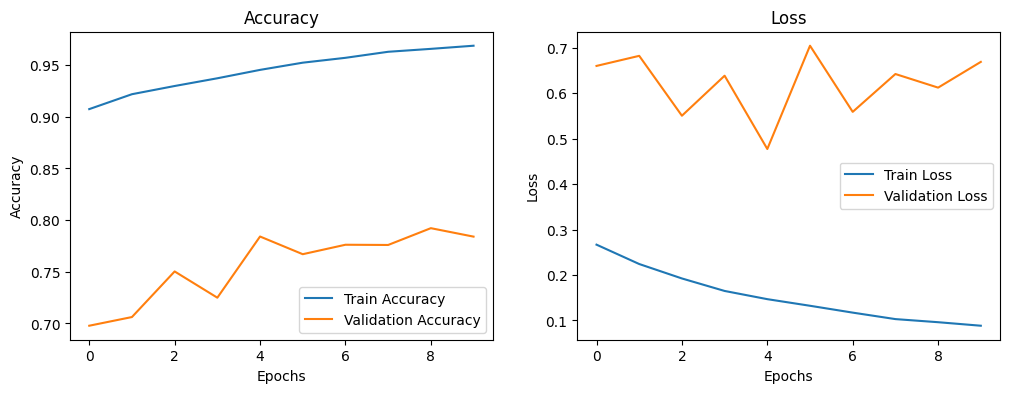

In [32]:
plot_training_history(history)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Fonction de prédiction avec probabilités
def predict_image_binary_with_probabilities(model_save, image_path):
    img = load_img(image_path, target_size=(128, 128))  # Adapter la taille à celle du modèle
    img_array = img_to_array(img)  # Conversion en tableau numpy
    img_array = np.expand_dims(img_array, axis=0)  # Ajouter la dimension batch
    img_array /= 255.0  # Normalisation de l'image

    # Prédiction binaire (probabilité unique)
    predictions = model_save.predict(img_array)
    probability = predictions[0][0]  # Probabilité que l'image soit une "Photo"
    
    # Classification basée sur la probabilité
    if probability > 0.5:
        predicted_class = 'Photo'
    else:
        predicted_class = 'Not-Photo'  # "Image" comme Not-Photo dans ce cas

    # Retourner la classe prédite et les probabilités (classe photo et non-photo)
    return predicted_class, [probability, 1 - probability]

# Fonction d'affichage des images avec probabilités
def display_images_with_binary_probabilities(model_save, dataset_dir, num_images=6):
    subfolders = ['Painting', 'Schematics', 'Sketch', 'Text']  # Liste des sous-dossiers d'images
    folder = ["Image","photo"]
    fig, axes = plt.subplots(2, num_images//2, figsize=(18, 8))  # Créer une grille pour afficher les images

    valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.gif']  # Extensions d'images valides

    for i in range(num_images):
        randomfolder = random.choice(folder) 
        if randomfolder == "photo":
             image_folder = os.path.join(dataset_dir, randomfolder) 
        else:
            subfolder = random.choice(subfolders)
            image_folder = os.path.join(dataset_dir, randomfolder, subfolder)  

        # Vérifier l'existence du sous-dossier
        if not os.path.exists(image_folder):
            print(f"Folder not found: {image_folder}")
            continue
        
        try:
            # Fichiers valides dans le sous-dossier
            valid_files = [f for f in os.listdir(image_folder) if os.path.splitext(f)[1].lower() in valid_extensions]
            
            if len(valid_files) == 0:
                print(f"No valid image files found in: {image_folder}")
                continue

            random_image = random.choice(valid_files)
            image_path = os.path.join(image_folder, random_image)

            # Charger l'image et obtenir la prédiction
            img = load_img(image_path, target_size=(256, 256))  # Pour une meilleure visibilité
            predicted_class, probabilities = predict_image_binary_with_probabilities(model_save, image_path)

            # Sélectionner l'emplacement dans la grille (axes)
            ax = axes[i // (num_images // 2), i % (num_images // 2)]
            ax.imshow(img)
            ax.axis('off')

            # Afficher la classe prédite et le pourcentage
            probability_photo = probabilities[0] * 100  # Probabilité que ce soit une "Photo"
            ax.set_title(f'Predicted Class: {predicted_class} ({probability_photo:.2f}%)', fontsize=12)

        except Exception as e:
            print(f"An error occurred: {e}")
            ax.text(0.5, 0.5, 'Image Not Found', horizontalalignment='center', verticalalignment='center', fontsize=14)
            ax.axis('off')
            continue

    plt.tight_layout()
    plt.show()



In [3]:
display_images_with_binary_probabilities(model, dataset_dir, num_images=9)

NameError: name 'model' is not defined

# Utilisation des Poids Sauvegarder


In [4]:
model_save_weights = Sequential()

In [5]:
model_save_weights.add(layers.Rescaling(1./255, input_shape=(128, 128, 3)))
model_save_weights.add(Conv2D(32, (3, 3), activation='relu'))
model_save_weights.add(MaxPooling2D(pool_size=(2, 2)))

model_save_weights.add(Conv2D(64, (3, 3), activation='relu'))
model_save_weights.add(MaxPooling2D(pool_size=(2, 2)))

model_save_weights.add(Conv2D(128, (3, 3), activation='relu'))
model_save_weights.add(MaxPooling2D(pool_size=(2, 2)))

model_save_weights.add(Flatten())
model_save_weights.add(Dense(128, activation='relu'))
model_save_weights.add(Dropout(0.5)) 
model_save_weights .add(Dense(64, activation='relu'))


model_save_weights.add(Dense(1, activation='sigmoid'))

c:\Users\steve\Documents\GitHub\DataSciencePictureDesc\data-science-env\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [6]:
model_save_weights.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [7]:
model_save_weights.load_weights('model_aumentation.weights.h5')

c:\Users\steve\Documents\GitHub\DataSciencePictureDesc\data-science-env\Lib\site-packages\keras\src\saving\saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


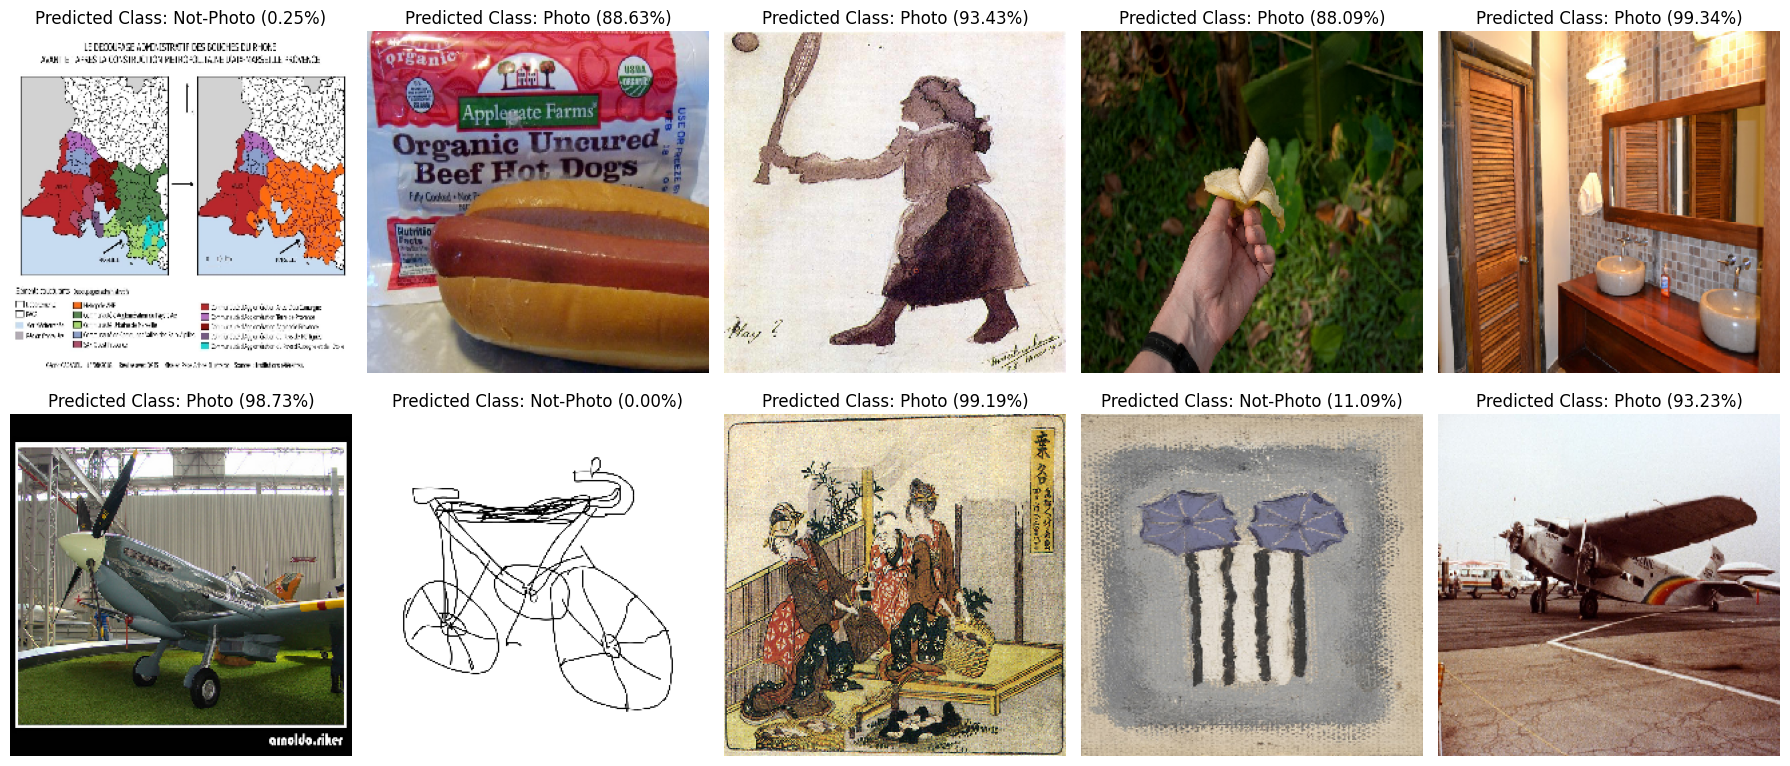

In [11]:
display_images_with_binary_probabilities(model_save_weights, dataset_dir, num_images=10)

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from lime import lime_image
from skimage.segmentation import mark_boundaries

# Fonction de prédiction avec probabilités
def predict_image_binary_with_probabilities(model_save, image_path):
    img = load_img(image_path, target_size=(128, 128)) 
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) 
    img_array /= 255.0 

    # Prédiction
    predictions = model_save.predict(img_array)
    probability = predictions[0][0]  
    
    # Classification
    if probability > 0.5:
        predicted_class = 'Photo'
    else:
        predicted_class = 'Not-Photo'  

    return predicted_class, [probability, 1 - probability]

# Fonction d'explication des prédictions avec LIME
def explain_image_with_lime(model_save, image_path):
    img = load_img(image_path, target_size=(128, 128))
    img_array = img_to_array(img) / 255.0  
    img_array = np.expand_dims(img_array, axis=0)

    explainer = lime_image.LimeImageExplainer()

    def model_predict(input_image):
        return model_save.predict(input_image)
    
    explanation = explainer.explain_instance(img_array[0], model_predict, top_labels=1, hide_color=0, num_samples=1000)

    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
    return temp, mask

# Fonction d'affichage des images avec probabilités et LIME côte à côte avec l'image originale
def display_images_with_binary_probabilities_and_lime(model_save, dataset_dir, num_images=6):
    subfolders = ['Painting', 'Schematics', 'Sketch', 'Text']
    folder = ["Image", "photo"]
    fig, axes = plt.subplots(2, num_images, figsize=(18, 8))  # On double le nombre de colonnes pour inclure l'originale

    valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.gif']

    for i in range(num_images):
        randomfolder = random.choice(folder)
        if randomfolder == "photo":
            image_folder = os.path.join(dataset_dir, randomfolder)
        else:
            subfolder = random.choice(subfolders)
            image_folder = os.path.join(dataset_dir, randomfolder, subfolder)

        if not os.path.exists(image_folder):
            print(f"Folder not found: {image_folder}")
            continue

        try:
            valid_files = [f for f in os.listdir(image_folder) if os.path.splitext(f)[1].lower() in valid_extensions]

            if len(valid_files) == 0:
                print(f"No valid image files found in: {image_folder}")
                continue

            random_image = random.choice(valid_files)
            image_path = os.path.join(image_folder, random_image)

            # Charger l'image d'origine et obtenir la prédiction
            img = load_img(image_path, target_size=(256, 256))  
            predicted_class, probabilities = predict_image_binary_with_probabilities(model_save, image_path)

            # Obtenir l'explication avec LIME
            temp, mask = explain_image_with_lime(model_save, image_path)

            # Sélectionner l'emplacement dans la grille pour l'image d'origine (axes)
            ax_original = axes[i // (num_images // 2), i % (num_images // 2) * 2]
            ax_original.imshow(img)  
            ax_original.axis('off')
            ax_original.set_title(f'Original Image', fontsize=12)

            # Sélectionner l'emplacement dans la grille pour l'image avec explication LIME (axes)
            ax_lime = axes[i // (num_images // 2), (i % (num_images // 2) * 2) + 1]
            ax_lime.imshow(mark_boundaries(temp / 255.0, mask))  
            ax_lime.axis('off')

            # Afficher la classe prédite et la probabilité sur l'image LIME
            probability_photo = probabilities[0] * 100  
            ax_lime.set_title(f'Predicted: {predicted_class} ({probability_photo:.2f}%)', fontsize=12)

        except Exception as e:
            print(f"An error occurred: {e}")
            ax_lime.text(0.5, 0.5, 'Image Not Found', horizontalalignment='center', verticalalignment='center', fontsize=14)
            ax_lime.axis('off')
            continue

    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━

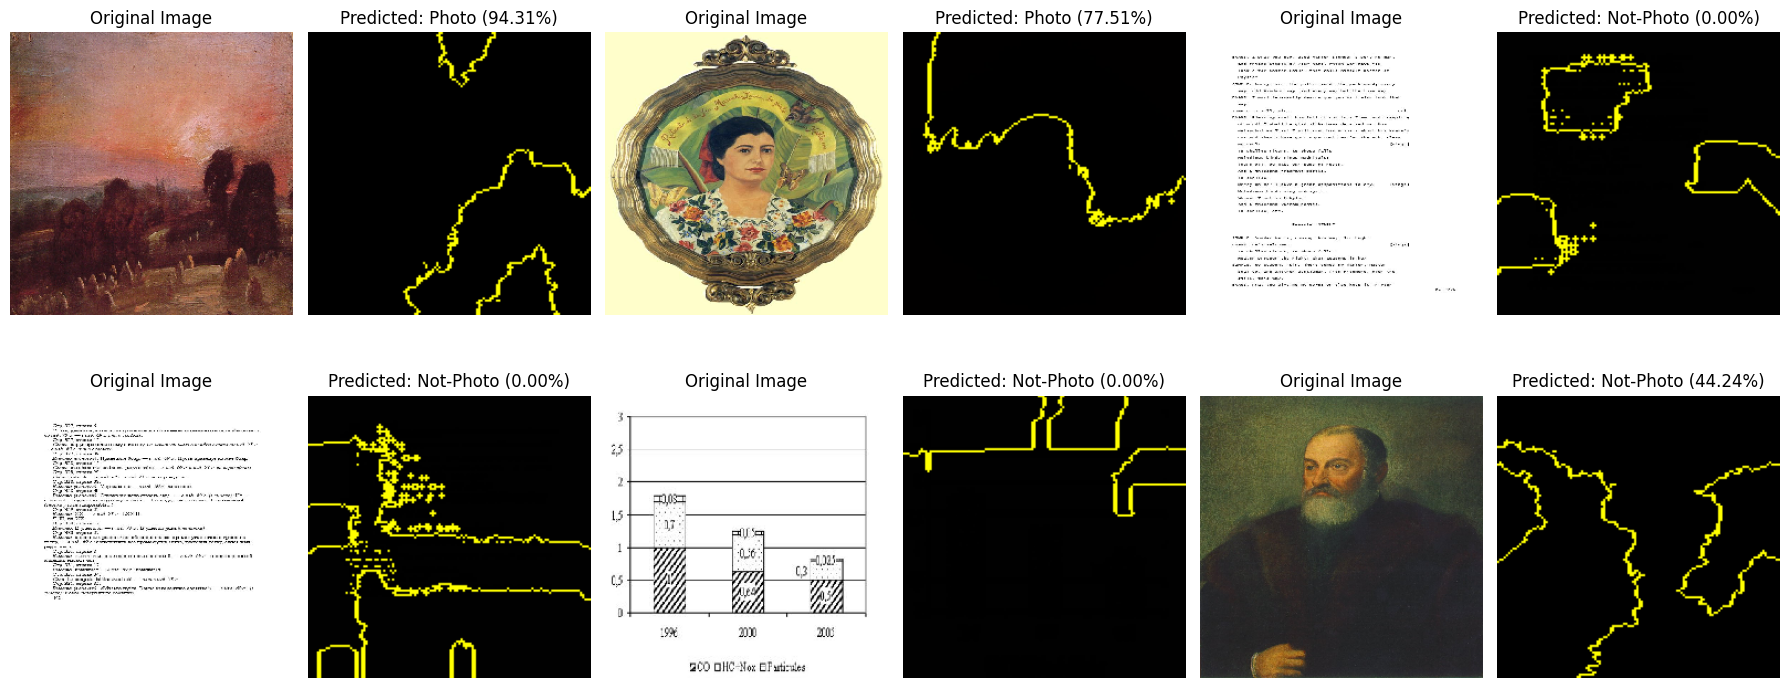

In [13]:
display_images_with_binary_probabilities_and_lime(model_save_weights, dataset_dir, num_images=6)